# Initialization
- import relevant libraries
- create device and img_size variables

In [ ]:
import torch
from torch import device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import math
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision.transforms import functional as trans_fn
import matplotlib.pyplot as plt
from skimage import io, transform
import albumentations as A
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import torchvision
import csv

In [ ]:
img_size = 256

In [ ]:
# to keep track of train/test loss curves
create_loss_csv = 0
if (create_loss_csv == 1):
    with open('fluo/train_test_loss.csv', 'w', newline='') as csvfile:
        fieldnames = ['epoch', 'train_loss', 'test_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# Prepare Data

In [ ]:
image_url = 'https://storage.googleapis.com/acv_project/floro_train.zip'
!curl -O $image_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.6M  100 21.6M    0     0  80.9M      0 --:--:-- --:--:-- --:--:-- 80.9M


In [ ]:
!unzip fluo/fluo_train.zip -d fluo
!unzip fluo/fluo_test.zip -d fluo

unzip:  cannot find or open fluo/fluo_train.zip, fluo/fluo_train.zip.zip or fluo/fluo_train.zip.ZIP.
unzip:  cannot find or open fluo/fluo_test.zip, fluo/fluo_test.zip.zip or fluo/fluo_test.zip.ZIP.


(1024, 1024)


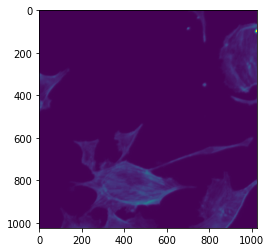

(1024, 1024)


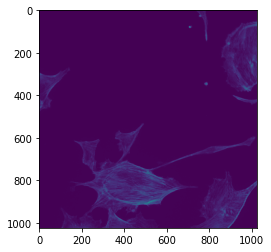

In [ ]:
# visualize data
img1_path = "fluo/data/train/input/mito_31-3.tif"
img = io.imread(img1_path)
print(img.shape)
plt.imshow(img)
plt.show()

sr1_path = "fluo/data/train/target/mito_31-3.tif"
sr = io.imread(sr1_path)
print(img.shape)
plt.imshow(sr)
plt.show()

# Dataset and Dataloader
code adapted from Xinwen Liu

In [ ]:
class Fluo_data(Dataset):
    def __init__(self, img_dir, transforms = None):
        self.transforms = Compose([A.RandomRotate90(p=0.5), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]) 

        # corresponding files have the same file names
        self.file_HR_dir = img_dir + '/target'
        self.file_HR = os.listdir(img_dir + '/target')
        self.file_SR_dir = img_dir + '/input'
    
    def __len__(self):
        return len(self.file_HR)
    
    def __getitem__(self,idx):
        try: 

            # read images and masks from directory.
            # Masks represent high-resolution images (targets) for low-res images.                
            img = io.imread(os.path.join(self.file_SR_dir, self.file_HR[idx])).astype('float32')
            size = 256
            img = transform.resize(img,(size,size))
            img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    
            mask = io.imread(os.path.join(self.file_HR_dir, self.file_HR[idx])).astype('float32')
            mask = transform.resize(mask,(size,size))
            mask = cv2.normalize(mask, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            augmented = self.transforms(image=img, mask=mask) # data augmentation
            img = augmented['image']
            mask = augmented['mask']
                
            # convert everything into a torch.Tensor
            mask = torch.as_tensor(mask, dtype=torch.float32)
            img = torch.as_tensor(img, dtype=torch.float32)

            img = img.unsqueeze(0)
            mask = mask.unsqueeze(0)

                        
            return {"file_name": self.file_HR[idx], "img": img, "mask": mask}
        
        except Exception as exc:
            return None

In [ ]:
image_datasets = {x: Fluo_data(os.path.join('./fluo/data', x)) for x in ['train', 'test']}

In [ ]:
image_datasets['test'][1]["file_name"]

'mito_3-1.tif'

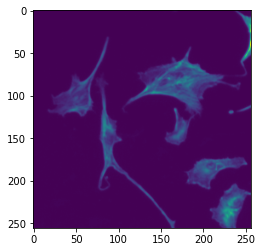

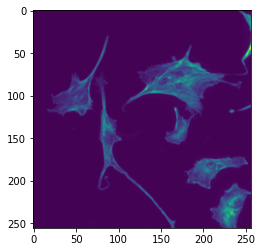

In [ ]:
# visualize data 
images = image_datasets['test'][1]
plt.imshow(images["img"].squeeze(0))
plt.show()
plt.imshow(images["mask"].squeeze(0))
plt.show()

In [ ]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    img = torch.stack([b["img"] for b in batch]) 
    mask = torch.stack([b["mask"] for b in batch])
    return {"HR": mask, "SR": img}

In [ ]:
# implement custom image_dataset and wrap it with the dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2, 
                                              shuffle=True, num_workers=0, collate_fn = collate_fn)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print('size of dataset', dataset_sizes)

size of dataset {'train': 48, 'test': 5}


In [ ]:
# Some utility functions to show images

# Convert tensor to image
def image_convert(image_in):
    image = image_in.clone().squeeze().cpu().numpy()
    image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return image

def plot_img(no_, data):
    images = []
    masks = []
    random_idx = np.random.choice(len(data),no_)
    for i in random_idx:
        im = data[i]
        images.append(im["img"])
        masks.append(im["mask"])
    plt.figure(figsize=(15,10))
    for idx in range(0,no_):
        image = image_convert(images[idx])
        plt.subplot(2,no_,idx+1)
        plt.title('Low-res image')
        plt.imshow(image, vmin=0, vmax=255)
    for idx in range(0,no_):
        mask = image_convert(masks[idx])
        plt.subplot(2,no_,idx+no_+1)
        plt.title('High-res image')
        plt.imshow(mask, vmin=0, vmax=255)
    plt.show()

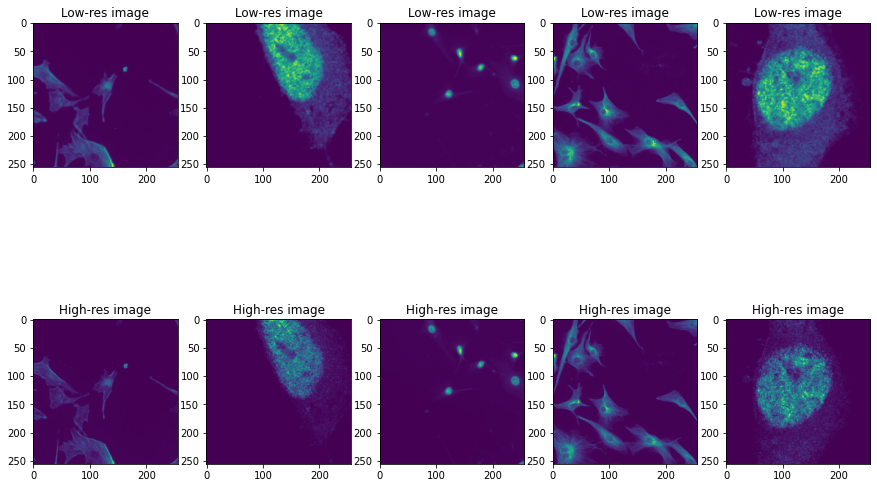

In [ ]:
plot_img(5, image_datasets['train'])

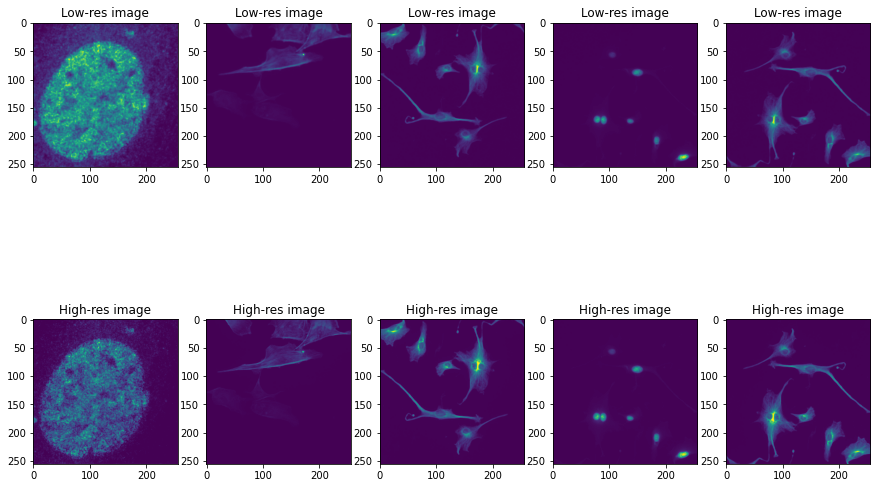

In [ ]:
plot_img(5, image_datasets['test'])

torch.Size([2, 1, 256, 256])


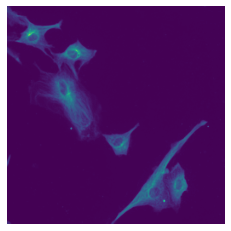

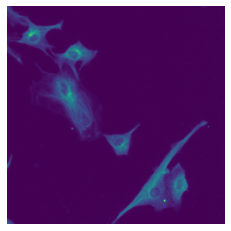

In [ ]:
# Get a batch of training data
batch = next(iter(dataloaders['train']))
print(batch["SR"].shape)

plt.axis("off")
plt.imshow(batch["HR"][0].squeeze(0))
plt.show()
plt.axis("off")
plt.imshow(batch["SR"][0].squeeze(0))
plt.show()

# Code for SR3 Model 
Modified https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement/blob/master/model/sr3_modules/diffusion.py (unoffical code for SR3)


Hyperparameters changed for Unet (with reference to config files for sr3):
- changed in_channel to 2 and out_channel to 1
- changed inner_channel from 64 to 32
- changed channel_mults from [1, 2, 4, 8, 8] to [1, 2, 4, 8]
- changed attn_res from [16] to [8]
- changed res_blocks from 2 to 1
- kept dropout at 0.2
- set image_size at 256

Hyperparameters changed for GaussianDiffusion:
- set timesteps as 1000 under set_new_noise_schedule()


Changes made: 
- remove use of base model and model_opt
- adjusted hyperparameters of the model so that it is smaller
- wrote training loop

In [ ]:
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        self.set_new_noise_schedule(device)

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, device, schedule="linear", n_timestep=1000, linear_start=1e-6, linear_end=0.01):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule,
            n_timestep=n_timestep,
            linear_start=linear_start,
            linear_end=linear_end)
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, continous=False):
        return self.p_sample_loop(x_in, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        # random gama
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['HR']
        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.FloatTensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            )
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(
            b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([x_in['SR'], x_noisy], dim=1), continuous_sqrt_alpha_cumprod)

        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

In [ ]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from inspect import isfunction


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=2, # should not be changed (takes in LR image as reference and the noise)
        out_channel=1, # should not be changed (should output an image)
        inner_channel=32,
        norm_groups=8,
        channel_mults=[1, 2, 4, 8],
        attn_res=[8],
        res_blocks=1,
        dropout=0.2,
        with_noise_level_emb=True,
        image_size=img_size
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

In [ ]:
model = UNet()

In [ ]:
def get_model_info(model):
    # Compute number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Compute the size of the model in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    return num_params, size_all_mb

In [ ]:
netG = GaussianDiffusion(model,img_size,device).to(device)
netG.set_loss(device)

In [ ]:
# Print model info
num_params, size_all_mb = get_model_info(netG)

print("Number of trainable params:", num_params)
print('Model size: {:.3f}MB'.format(size_all_mb))

Number of trainable params: 9734817
Model size: 37.181MB


In [ ]:
optG = torch.optim.Adam(netG.parameters(), lr=1e-4)

HR image


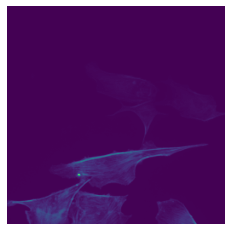

SR image


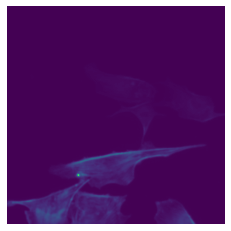

resulting image


sampling loop time step: 100%|██████████| 1000/1000 [00:16<00:00, 62.24it/s]


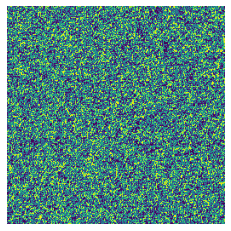

In [ ]:
# visualize image
visualize_image = image_datasets['test'][4]

print("HR image")
plt.axis("off")
plt.imshow(visualize_image['mask'].squeeze(0))
plt.show()

print("SR image")
plt.axis("off")
plt.imshow(visualize_image['img'].squeeze(0))
plt.show()

print("resulting image")
plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['img'][None,:].to(device)).squeeze(0).cpu())
plt.show()

# Training loop

Wrote training loop and added visualization in training process

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])     

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def train_model(netG, optG, start_epoch=0, end_epoch=10):

    for epoch in range(start_epoch, end_epoch):
        loss_dict = {'epoch': epoch, 'train_loss': -100, 'test_loss': -100}
        print(f'Epoch {epoch}/{end_epoch - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                netG.train()  # Set model to training mode
            else:
                netG.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch in tqdm(dataloaders[phase]):
                HR_img = batch["HR"].to(device)
                SR_img = batch["SR"].to(device)

                # zero the parameter gradients
                optG.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    l_pix = netG({"HR": HR_img, "SR": SR_img})

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l_pix.backward()
                        optG.step()

                    # statistics
                    running_loss += l_pix.item()

            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                loss_dict['train_loss'] = epoch_loss
            else:
                loss_dict['test_loss'] = epoch_loss

            print(f'{phase} Loss: {epoch_loss:.4f}')

        if (epoch%20 == 0):
            # write loss to csv
            with open('fluo/train_test_loss.csv', 'a', newline='') as csvfile:
                fieldnames = ['epoch', 'train_loss', 'test_loss']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerows([loss_dict])

            # plot results for visualization
            plt.axis("off")
            plt.imshow(netG.super_resolution(visualize_image['img'][None,:].to(device)).permute(1, 2, 0).cpu())
            plt.show()

            print()

            # save checkpoint
            checkpoint = {
                "state_dict": netG.state_dict(),
                "optimizer": optG.state_dict(),
            }
            
            save_checkpoint(checkpoint, f'./fluo/model_weights/epoch{epoch}.pth.tar')
            print()

Epoch 0/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


train Loss: 2557.3907


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


test Loss: 859.9729


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 64.97it/s]


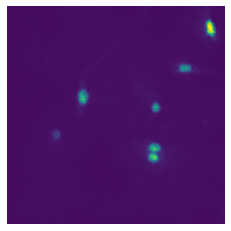


=> Saving checkpoint

Epoch 1/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 3083.9669


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


test Loss: 1054.6214
Epoch 2/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


train Loss: 2545.5029


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


test Loss: 5131.0542
Epoch 3/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1086.5580


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


test Loss: 1623.0530
Epoch 4/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1105.9148


100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


test Loss: 5296.2188
Epoch 5/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


train Loss: 2353.2696


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


test Loss: 717.6584
Epoch 6/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1624.6467


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


test Loss: 5142.4672
Epoch 7/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 3351.2422


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


test Loss: 798.1339
Epoch 8/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


train Loss: 2778.0188


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


test Loss: 3187.1209
Epoch 9/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 2419.4626


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


test Loss: 1073.2887
Epoch 10/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 1738.8852


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


test Loss: 1368.5293
Epoch 11/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 1425.2410


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


test Loss: 1562.3959
Epoch 12/199
----------


100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


train Loss: 1202.3037


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


test Loss: 1951.7550
Epoch 13/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1014.3035


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


test Loss: 761.8954
Epoch 14/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 2297.7823


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


test Loss: 2320.4440
Epoch 15/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 2283.1387


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


test Loss: 1346.5654
Epoch 16/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 2293.6294


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


test Loss: 3064.6259
Epoch 17/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1239.0297


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


test Loss: 730.2551
Epoch 18/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


train Loss: 1273.5793


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


test Loss: 885.2705
Epoch 19/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


train Loss: 1832.4121


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


test Loss: 1996.8994
Epoch 20/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


train Loss: 2309.2926


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


test Loss: 1832.1755


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 64.32it/s]


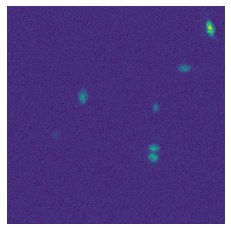


=> Saving checkpoint

Epoch 21/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1674.5595


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


test Loss: 798.9378
Epoch 22/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1375.0609


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


test Loss: 1031.3114
Epoch 23/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 2125.1623


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


test Loss: 3364.5885
Epoch 24/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


train Loss: 1572.3768


100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


test Loss: 784.9051
Epoch 25/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


train Loss: 1964.9456


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


test Loss: 767.0663
Epoch 26/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1563.3956


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


test Loss: 1585.7239
Epoch 27/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 2013.2588


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


test Loss: 2326.9877
Epoch 28/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 1745.9349


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


test Loss: 1924.0872
Epoch 29/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1148.5914


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


test Loss: 1663.2755
Epoch 30/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 2573.8224


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


test Loss: 6627.7068
Epoch 31/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


train Loss: 1587.0262


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


test Loss: 917.9219
Epoch 32/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


train Loss: 1389.5741


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


test Loss: 1009.4740
Epoch 33/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.78it/s]


train Loss: 2910.4856


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


test Loss: 19525.1882
Epoch 34/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1470.7364


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


test Loss: 678.4340
Epoch 35/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


train Loss: 4226.8675


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


test Loss: 2142.9000
Epoch 36/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1923.0456


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


test Loss: 689.1621
Epoch 37/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1231.1580


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


test Loss: 1975.6635
Epoch 38/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 2273.5029


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


test Loss: 2473.9106
Epoch 39/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 2408.5964


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


test Loss: 1780.5795
Epoch 40/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


train Loss: 2712.0462


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


test Loss: 8424.1634


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.91it/s]


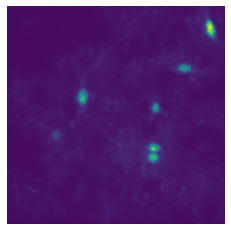


=> Saving checkpoint

Epoch 41/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


train Loss: 2258.0005


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


test Loss: 987.6562
Epoch 42/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


train Loss: 3390.0292


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


test Loss: 10139.7885
Epoch 43/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1455.8175


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


test Loss: 1812.8190
Epoch 44/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


train Loss: 1788.1384


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


test Loss: 703.5330
Epoch 45/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1748.0832


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


test Loss: 1171.2147
Epoch 46/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1642.7619


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


test Loss: 2611.0069
Epoch 47/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1825.0417


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


test Loss: 1427.0261
Epoch 48/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1139.8721


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


test Loss: 862.5061
Epoch 49/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 2050.5828


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


test Loss: 1091.0112
Epoch 50/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 2732.3506


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


test Loss: 963.8057
Epoch 51/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


train Loss: 2803.8096


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


test Loss: 788.5922
Epoch 52/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 1107.0527


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


test Loss: 1205.2157
Epoch 53/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 1620.6699


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


test Loss: 2196.1201
Epoch 54/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.78it/s]


train Loss: 2216.3918


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


test Loss: 926.5074
Epoch 55/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 3131.8483


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


test Loss: 8382.5060
Epoch 56/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1700.7707


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


test Loss: 874.2261
Epoch 57/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1166.0625


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


test Loss: 780.8323
Epoch 58/199
----------


100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


train Loss: 1633.1085


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


test Loss: 2225.5465
Epoch 59/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1277.1034


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 1430.5691
Epoch 60/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 2619.7819


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


test Loss: 1794.1257


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


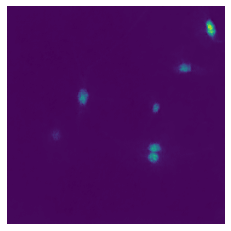


=> Saving checkpoint

Epoch 61/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1885.5362


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


test Loss: 2373.6391
Epoch 62/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1125.0704


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


test Loss: 823.4453
Epoch 63/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1222.3983


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


test Loss: 968.4994
Epoch 64/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 1594.7688


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


test Loss: 769.9296
Epoch 65/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1294.6769


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


test Loss: 1422.5311
Epoch 66/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


train Loss: 1638.9594


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


test Loss: 4814.2456
Epoch 67/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1189.0967


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 1204.5077
Epoch 68/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


train Loss: 1485.6255


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


test Loss: 3416.2198
Epoch 69/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1739.0580


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


test Loss: 813.1146
Epoch 70/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 2116.6587


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


test Loss: 3047.6793
Epoch 71/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1303.5825


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


test Loss: 823.9952
Epoch 72/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1450.2213


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


test Loss: 1901.3156
Epoch 73/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 3330.1506


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


test Loss: 2090.9663
Epoch 74/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1521.7961


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


test Loss: 6109.1011
Epoch 75/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1778.7859


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


test Loss: 1296.4776
Epoch 76/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1512.2336


100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


test Loss: 1584.3829
Epoch 77/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 3252.4924


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


test Loss: 1596.6921
Epoch 78/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


train Loss: 1914.7875


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


test Loss: 7197.9735
Epoch 79/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


train Loss: 3691.7602


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


test Loss: 4626.4650
Epoch 80/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 3513.9962


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


test Loss: 2546.5461


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.63it/s]


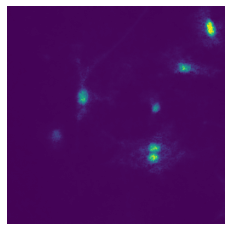


=> Saving checkpoint

Epoch 81/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


train Loss: 1932.4725


100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


test Loss: 1716.6653
Epoch 82/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 3607.1855


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


test Loss: 796.3936
Epoch 83/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1232.1285


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


test Loss: 661.0308
Epoch 84/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


train Loss: 1667.2808


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


test Loss: 820.7172
Epoch 85/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1199.9798


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


test Loss: 545.8906
Epoch 86/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1884.2239


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 1159.8901
Epoch 87/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1819.5094


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


test Loss: 622.3856
Epoch 88/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 2420.4639


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


test Loss: 1699.5337
Epoch 89/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 2240.7974


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


test Loss: 10870.6026
Epoch 90/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


train Loss: 1307.4873


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 1098.4041
Epoch 91/199
----------


100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


train Loss: 3425.8235


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


test Loss: 881.4250
Epoch 92/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1707.2284


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


test Loss: 920.8244
Epoch 93/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1677.6665


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 5426.0770
Epoch 94/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


train Loss: 2008.0819


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


test Loss: 1704.4265
Epoch 95/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 2097.3833


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 5372.1102
Epoch 96/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 4020.1528


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


test Loss: 3074.6181
Epoch 97/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


train Loss: 3094.5553


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


test Loss: 1793.3399
Epoch 98/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


train Loss: 1292.1379


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


test Loss: 893.6185
Epoch 99/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 2210.0840


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 4692.7477
Epoch 100/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1654.6274


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


test Loss: 808.8335


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.77it/s]


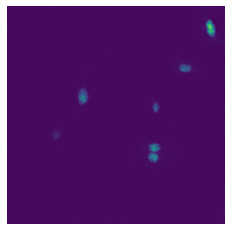


=> Saving checkpoint

Epoch 101/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1107.1185


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


test Loss: 3782.9699
Epoch 102/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


train Loss: 2773.4185


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


test Loss: 2239.0520
Epoch 103/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1277.6178


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


test Loss: 1110.6361
Epoch 104/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 1362.2375


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


test Loss: 3961.4466
Epoch 105/199
----------


100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


train Loss: 1402.4982


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


test Loss: 959.0408
Epoch 106/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1822.2197


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


test Loss: 3842.6170
Epoch 107/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


train Loss: 2175.2725


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


test Loss: 5098.1790
Epoch 108/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


train Loss: 1391.4850


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


test Loss: 1022.1683
Epoch 109/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1619.5691


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


test Loss: 1951.2582
Epoch 110/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 1236.5806


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


test Loss: 1028.3231
Epoch 111/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1983.0183


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


test Loss: 1158.4589
Epoch 112/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 1664.6540


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 724.3528
Epoch 113/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1177.9997


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 727.7600
Epoch 114/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1203.5980


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 4734.5043
Epoch 115/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1922.9202


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


test Loss: 2129.3427
Epoch 116/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


train Loss: 1433.7153


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


test Loss: 1029.0819
Epoch 117/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


train Loss: 1771.7907


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


test Loss: 674.1029
Epoch 118/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1416.3557


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


test Loss: 706.4278
Epoch 119/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 2892.9094


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


test Loss: 935.0200
Epoch 120/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


train Loss: 1307.8554


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


test Loss: 2975.7912


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.31it/s]


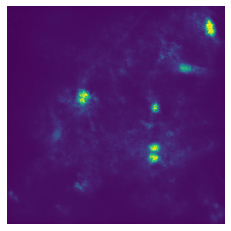


=> Saving checkpoint

Epoch 121/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


train Loss: 1914.7736


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


test Loss: 3185.1066
Epoch 122/199
----------


100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


train Loss: 2921.0658


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


test Loss: 1339.6744
Epoch 123/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


train Loss: 2071.3545


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 921.9671
Epoch 124/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1675.4708


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


test Loss: 1843.1030
Epoch 125/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


train Loss: 2581.7728


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


test Loss: 7801.7567
Epoch 126/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


train Loss: 1911.1773


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


test Loss: 1953.7018
Epoch 127/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 1638.8724


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


test Loss: 1508.6811
Epoch 128/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 1826.0650


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


test Loss: 507.1434
Epoch 129/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


train Loss: 2012.7425


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


test Loss: 3891.9410
Epoch 130/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 1157.5160


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


test Loss: 4517.1682
Epoch 131/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


train Loss: 2205.0843


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


test Loss: 694.5040
Epoch 132/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1520.2767


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


test Loss: 746.0214
Epoch 133/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.71it/s]


train Loss: 2071.7523


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


test Loss: 1153.6220
Epoch 134/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


train Loss: 1463.9829


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


test Loss: 1639.4506
Epoch 135/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


train Loss: 1388.4555


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


test Loss: 796.2073
Epoch 136/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


train Loss: 3307.3762


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


test Loss: 8823.1004
Epoch 137/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


train Loss: 1165.4484


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


test Loss: 2368.6582
Epoch 138/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


train Loss: 3217.2605


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


test Loss: 857.6449
Epoch 139/199
----------


100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


train Loss: 1758.8733


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


test Loss: 3146.9470
Epoch 140/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 968.8441


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


test Loss: 5608.8906


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.40it/s]


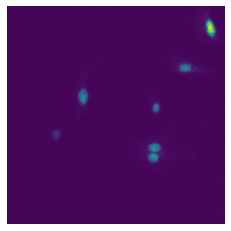


=> Saving checkpoint

Epoch 141/199
----------


100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


train Loss: 2154.7253


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


test Loss: 840.5105
Epoch 142/199
----------


 12%|█▎        | 3/24 [00:02<00:14,  1.44it/s]


KeyboardInterrupt: ignored

In [ ]:
# load checkpoint then train
epoch=0
#load_checkpoint(torch.load(f'./fluo/model_weights/epoch{epoch}.pth.tar'), netG, optG)
train_model(netG, optG, start_epoch=0, end_epoch=200)

Epoch 200/200
----------


100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


train Loss: 2715.5783


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


test Loss: 2647.8072


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 64.82it/s]


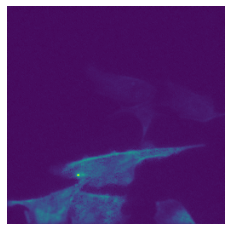


=> Saving checkpoint



In [ ]:
train_model(netG, optG, start_epoch=200, end_epoch=201)

# Load saved model

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])     

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

HR image


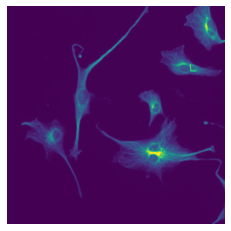

SR image


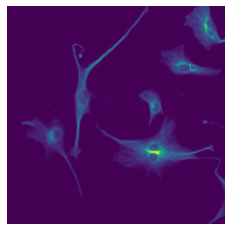

=> Loading checkpoint


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.15it/s]


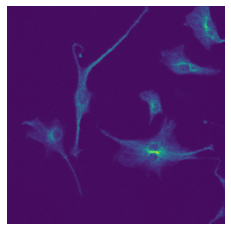

In [ ]:
visualize_image = image_datasets['test'][0]

print("HR image")
plt.axis("off")
plt.imshow(visualize_image['mask'].squeeze(0))
plt.show()

print("SR image")
plt.axis("off")
plt.imshow(visualize_image['img'].squeeze(0))
plt.show()

load_checkpoint(torch.load("./fluo/model_weights/epoch140.pth.tar"), netG, optG)

plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['img'][None,:].to(device)).squeeze(0).cpu())
plt.show()

# Performance evaluation on testing dataset
modified from Xinwen's code

In [ ]:
!pip install torchmetrics
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
import lpips
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
loss_fn = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.squeeze(0)
    image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return image

In [ ]:
# Evaluate model performance on test dataset
def test_eval(test_data, model):
    l1_loss = []
    mse_loss = []
    psnr_list = []
    ssim_list = []
    output_list = []
    lpips_list = []
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()

    model.eval()
    with torch.no_grad():
        for i in range(len(test_data)):
            images = test_data[i]
            input = images['img']
            target = images['mask']
            input = input.to(device)
            target = target.to(device)
            output = netG.super_resolution(input[None,:])
            output_list.append(output.clone().cpu().detach().numpy())

            # Compute L1 loss
            loss = criterion1(output,target)
            l1_loss.append(loss.item())

            # Compute MSE loss
            loss2 = criterion2(output,target)
            mse_loss.append(loss2.item())

            # Compute PSNR 
            psnr_value = psnr(output.to(device), target)
            psnr_value = psnr_value.clone().cpu().detach().numpy()
            psnr_list.append(psnr_value)
            
            # Compute SSIM
            ssim_value = ssim(output.unsqueeze(0), target.unsqueeze(0))
            ssim_value = ssim_value.clone().cpu().detach().numpy()
            ssim_list.append(ssim_value)

            # Compute LPIPS
            d = loss_fn.forward(output,target).clone().cpu().detach().numpy()
            lpips_list.append(d)

            # Display the LR image, output image and HR image.
            plt.figure(i)
            fig, axs = plt.subplots(1, 3, figsize=(15, 10))
            axs[0].imshow(image_convert(input))
            axs[0].set_title('LR image')
            axs[1].imshow(image_convert(output))
            axs[1].set_title('Output image')
            axs[2].imshow(image_convert(target))
            axs[2].set_title('HR image (Ground Truth)')
            plt.savefig("fluo/results/test_image{}.pdf".format(i), format = "pdf", bbox_inches = "tight")
            plt.show()
    return l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list

=> Loading checkpoint


sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.13it/s]


<Figure size 432x288 with 0 Axes>

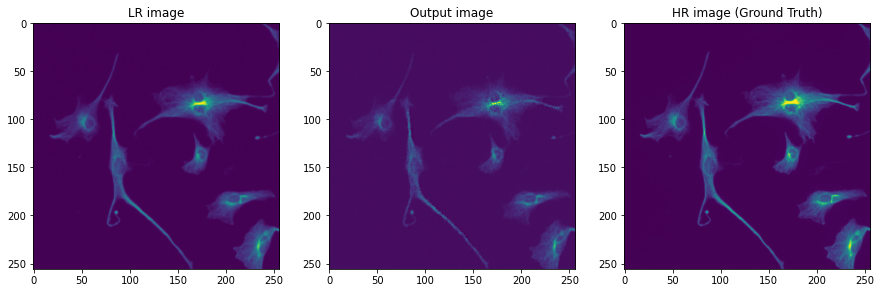

sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.76it/s]


<Figure size 432x288 with 0 Axes>

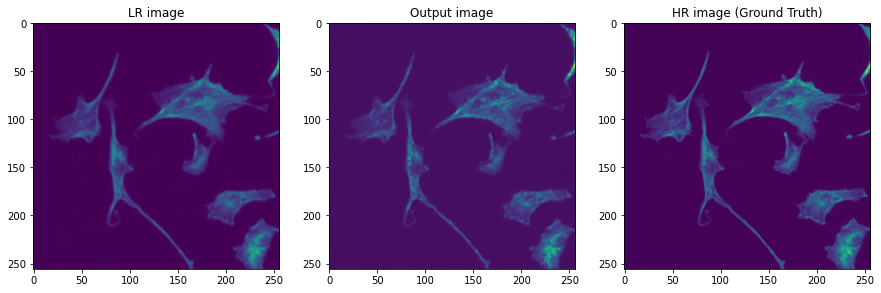

sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.30it/s]


<Figure size 432x288 with 0 Axes>

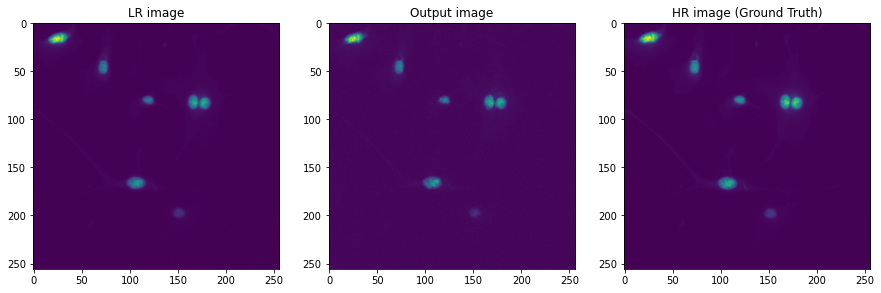

sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.88it/s]


<Figure size 432x288 with 0 Axes>

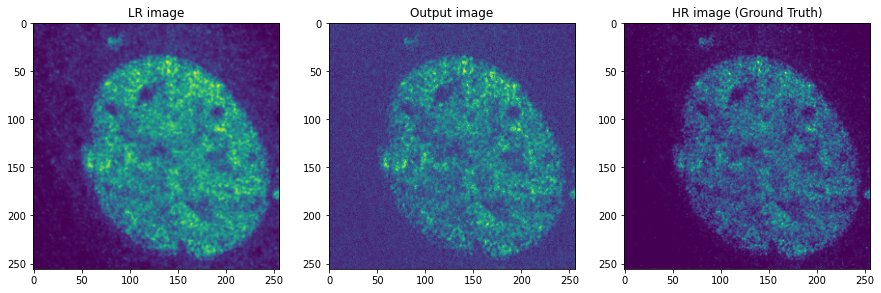

sampling loop time step: 100%|██████████| 1000/1000 [00:15<00:00, 63.69it/s]


<Figure size 432x288 with 0 Axes>

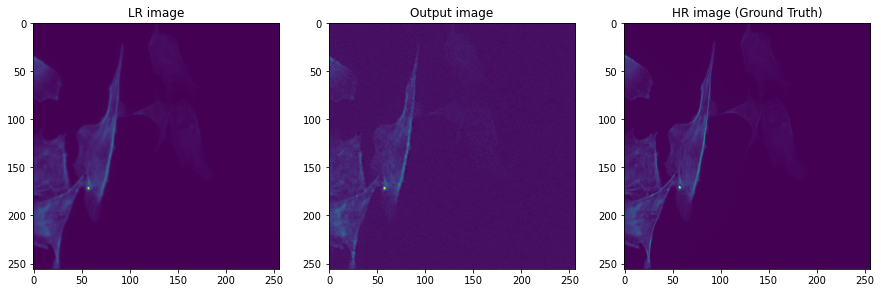

In [ ]:
load_checkpoint(torch.load("./fluo/model_weights/epoch140.pth.tar"), netG, optG)

l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list = test_eval(image_datasets['test'], netG)

In [ ]:
!zip -r fluo_results_diffusion_epoch280.zip fluo/results

  adding: fluo/results/ (stored 0%)
  adding: fluo/results/test_image2.pdf (deflated 11%)
  adding: fluo/results/test_image4.pdf (deflated 7%)
  adding: fluo/results/test_image3.pdf (deflated 2%)
  adding: fluo/results/test_image1.pdf (deflated 7%)
  adding: fluo/results/test_image0.pdf (deflated 8%)


In [ ]:
print(np.mean(l1_loss))
print(np.mean(mse_loss))
print(np.mean(psnr_list))
print(np.mean(lpips_list))
print(np.mean(ssim_list))

0.03997937440872192
0.004800462757702917
25.796991
0.089756474
0.23469873


In [ ]:
import torch
torch.cuda.empty_cache()